Here I'm going to explore the notification moduel and how they work. First, I need to understand their fields

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline
from datetime import datetime, timedelta

# LOAD DOS DADOS

In [2]:
df = pd.read_json("../../data/raw_data/base_22012019.json")

In [3]:
grades_df = pd.read_excel("../../data/raw_data/nota_provas.xls")

Estas são as datas onde as avaliação dos alunos que compõe a base ocorreram.

In [4]:
date_v1 = datetime(day=10, year=2018, month=12)
date_v2 = datetime(day=11, month=2, year=2019)
date_v3 = datetime(day=18, month=3, year=2019)

# EXPLORAÇÃO inicial

In [5]:
notifications_df = df[df["model"] == "notifications.notification"]

In [6]:
notifications_df.shape

(13219, 3)

In [7]:
df["model"].value_counts()

log.log                             72464
sessions.session                    34450
notifications.notification          13219
mural.muralvisualizations            2464
questionary.useranswer               2132
banco_questoes.alternative           1680
chat.talkmessages                     725
chat.chatvisualizations               721
goals.mygoals                         638
questionary.userquest                 562
oauth2_provider.refreshtoken          442
oauth2_provider.accesstoken           442
banco_questoes.question               420
fcm_django.fcmdevice                  410
subjects.tag                          212
topics.resource                       162
chat.conversation                     135
pdf_file.pdffile                      109
users.user                            106
django_cron.cronjoblog                 78
questionary.specification              40
pendencies.pendencies                  37
mural.comment                          28
mural.mural                       

In [8]:
notifications_df["fields"].head(10)[34636]

{'meta': None,
 'task': 1,
 'user': 8,
 'level': 3,
 'viewed': False,
 'creation_date': '2018-10-28'}

Uma notificação possui os seguintes campos no log:
1. meta: 
2. user: que coleta o id do user para qual a notificação foi enviada
3. Level: O nível da notificação está relacionado à tarefa que ela notifica sobre, este campo possui 4 valores mas somente 3 significados
    
    3.1 1,2: Significam que a tarefa está em dia 
    
    3.2 3: Significa que a tarefa está atrasada
    
    3.3 4: Significa que o prazo para realizar a tarefa já acabou
4. viewed: que possui valor de verdadeiro ou falso indicando se a notifcação foi vista ou não pelo usuário
5. creation_date: A data de criação daquela notificação
6. task: id da task que aquela notificação está associada

# Limpeza dos dados

é preciso extrair as colunas existentes dentro da coluna "fields", para isso, eu vou utilizar a função json_normalize, nativa do pandas.

In [9]:
def extract_flatten_dataframe(df, column, meta_list):
    df_fields = json_normalize(data=df[column], meta=meta_list)
    df_fields.index = df.index
    return df_fields.join(df, how="outer")

In [10]:
notification_fields = json_normalize(data=notifications_df["fields"], meta=["meta", "task", "user", "level", "viewed", "creation_date"] )
notification_fields.index = notifications_df.index
notification_fields = notification_fields.astype({"level": pd.CategoricalDtype()})
notification_fields["creation_date"] = pd.to_datetime(notification_fields["creation_date"])
notification_df_flatted = notification_fields.join(notifications_df, how="outer")

In [11]:
notification_df_flatted.dtypes

creation_date    datetime64[ns]
level                  category
meta                     object
task                      int64
user                      int64
viewed                     bool
fields                   object
model                    object
pk                       object
dtype: object

In [12]:
notification_df_flatted.sample(10)

,creation_date,level,meta,task,user,viewed,fields,model,pk
42181,2018-12-07,4,None,8,17,True,"{'meta': None, 'task': 8, 'user': 17, 'level':...",notifications.notification,7748
42995,2018-12-14,1,None,42,73,False,"{'meta': None, 'task': 42, 'user': 73, 'level'...",notifications.notification,8612
35330,2018-11-08,1,None,10,50,False,"{'meta': None, 'task': 10, 'user': 50, 'level'...",notifications.notification,697
40389,2018-11-29,1,None,37,69,False,"{'meta': None, 'task': 37, 'user': 69, 'level'...",notifications.notification,5876
40178,2018-11-28,4,None,8,68,False,"{'meta': None, 'task': 8, 'user': 68, 'level':...",notifications.notification,5655
46993,2019-01-21,1,None,45,34,True,"{'meta': None, 'task': 45, 'user': 34, 'level'...",notifications.notification,12640
42296,2018-12-08,3,None,17,17,True,"{'meta': None, 'task': 17, 'user': 17, 'level'...",notifications.notification,7873
35623,2018-11-09,1,None,7,79,False,"{'meta': None, 'task': 7, 'user': 79, 'level':...",notifications.notification,990
38742,2018-11-23,1,None,37,70,False,"{'meta': None, 'task': 37, 'user': 70, 'level'...",notifications.notification,4169
46851,2019-01-20,3,None,19,28,True,"{'meta': None, 'task': 19, 'user': 28, 'level'...",notifications.notification,12498


In [13]:
notification_fields.dtypes

creation_date    datetime64[ns]
level                  category
meta                     object
task                      int64
user                      int64
viewed                     bool
dtype: object

Como dá pra ver o pandas não consegue inferir muito bem os data types das colunas, vou utilizar meu conhecimento sobre elas para colocar valores mais baratos e que correspondem melhor aos seus valores.m

# Logs

In [15]:
logs_default_df = df.loc[df["model"] == "log.log"]
log_meta_list = ["component", "context", "action", "resource", "user", "user_id", "user_email", "datetime"]
logs_df = extract_flatten_dataframe(logs_default_df, "fields", log_meta_list)

In [16]:
logs_df["action"].value_counts()

view                         38173
watch                        13181
access                       12013
logout                        2758
answer                        2173
finish                        1043
create                         738
send                           652
update                         536
view_history                   224
view_statistics                205
search                         150
click                          101
submit                          94
start                           86
cron                            64
participating                   52
delete                          48
initwebconference               32
participate                     30
create_comment                  27
create_post                     24
delete_post                     20
set_goal                        20
access_difficulties_modal        7
delete_comment                   4
view_list_of_news                3
edit_comment                     2
send_difficulties   

In [17]:
logs_df.loc[logs_df["action"] == "view"].component.value_counts()

resources             19687
topic                  5976
subject                3752
mobile                 2089
pendencies             1945
chat                   1662
mural                  1542
category               1493
Category_Dashboard       13
General_Dashboard        13
admin_log                 1
Name: component, dtype: int64

In [18]:
logs_df.columns

Index(['action', 'component', 'context', 'context.bulletin_id',
       'context.bulletin_name', 'context.bulletin_slug', 'context.category_id',
       'context.category_name', 'context.category_slug', 'context.comment_id',
       'context.condition', 'context.dependencies', 'context.goals_id',
       'context.goals_name', 'context.goals_slug', 'context.group_id',
       'context.group_name', 'context.group_slug', 'context.history_page',
       'context.is_correct', 'context.new_creator', 'context.new_creator_user',
       'context.new_slug', 'context.new_title', 'context.notification',
       'context.notification_id', 'context.pdffile_id', 'context.pdffile_name',
       'context.pdffile_slug', 'context.post_id', 'context.post_space_id',
       'context.post_space_name', 'context.post_space_slug',
       'context.question_content', 'context.question_id',
       'context.questionary_id', 'context.questionary_name',
       'context.questionary_slug', 'context.resource_id',
       'contex

# View Logs

In [19]:
view_logs_df = logs_df.loc[logs_df["action"] == "view"].dropna(axis=1, how="all")

In [20]:
view_logs_df.shape

(38173, 58)

In [21]:
view_logs_df.columns

Index(['action', 'component', 'context', 'context.bulletin_id',
       'context.bulletin_name', 'context.bulletin_slug', 'context.category_id',
       'context.category_name', 'context.category_slug', 'context.goals_id',
       'context.goals_name', 'context.goals_slug', 'context.pdffile_id',
       'context.pdffile_name', 'context.pdffile_slug', 'context.post_id',
       'context.post_space_id', 'context.post_space_name',
       'context.post_space_slug', 'context.questionary_id',
       'context.questionary_name', 'context.questionary_slug',
       'context.resource_id', 'context.resource_name', 'context.resource_slug',
       'context.search_by', 'context.student', 'context.subject_id',
       'context.subject_name', 'context.subject_slug', 'context.talk_id',
       'context.timestamp_end', 'context.timestamp_start', 'context.topic_id',
       'context.topic_name', 'context.topic_slug', 'context.user_email',
       'context.user_id', 'context.user_name', 'context.view_page',
       

# Watch Logs

In [22]:
watch_logs_df = logs_df.loc[logs_df["action"] == "watch"].dropna(axis=1, how="all")
watch_logs_df.shape

(13181, 25)

# Answer logs

In [23]:
answer_logs_df = logs_df.loc[logs_df["action"] == "answer"].dropna(axis=1, how="all")
answer_logs_df.shape

(2173, 18)

# Finish logs

In [24]:
finish_logs_df = logs_df.loc[logs_df["action"] == "finish"].dropna(axis=1, how="all")
finish_logs_df.shape

(1043, 27)

In [25]:
finish_logs_df.dtypes

action                       object
component                    object
context.category_id         float64
context.category_name        object
context.category_slug        object
context.questionary_id      float64
context.questionary_name     object
context.questionary_slug     object
context.subject_id          float64
context.subject_name         object
context.subject_slug         object
context.timestamp_end        object
context.timestamp_start      object
context.topic_id            float64
context.topic_name           object
context.topic_slug           object
context.ytvideo_id          float64
context.ytvideo_name         object
context.ytvideo_slug         object
datetime                     object
resource                     object
user                         object
user_email                   object
user_id                       int64
fields                       object
model                        object
pk                           object
dtype: object

In [59]:
finish_logs_df.resource.value_counts()

ytvideo        730
questionary    313
Name: resource, dtype: int64

In [55]:
finish_logs_df.user_email.value_counts()

12547002426@r1.br             32
10499649427@r1.br             30
12228811440@r1.br             29
09918375418@r1.br             29
analia@r1.br                  26
70311746438@r1.br             25
jaine-fer@hotmail.com         25
11066590400@r1.br             25
02536903583@r1.br             25
05386135562@r1.br             24
06649884588@r1.br             23
05375733560@r1.br             23
09958033402@r1.br             23
10321600479@r1.br             23
12048255485@r1.br             22
09933013475@r1.br             21
12197489780@r1.br             21
02358048518@r1.br             19
86025199582@r1.br             19
04508616518@r1.br             18
08703735443@r1.br             18
huri2997@r1.br                17
05228647597@r1.br             17
11391035470@r1.br             16
10312179405@r1.br             16
06503100558@r1.br             15
11303369486@r1.br             15
matheusvitorsg@gmail.com      14
joao.sedraz@univasf.edu.br    14
06271470548@r1.br             14
          

# Send logs

In [26]:
send_logs_df = logs_df.loc[logs_df["action"] == "send"].dropna(axis=1, how="all")
send_logs_df.shape

(652, 18)

In [31]:
send_logs_df.columns

Index(['action', 'component', 'context.post_id', 'context.subject_id',
       'context.subject_name', 'context.subject_slug', 'context.talk_id',
       'context.user_email', 'context.user_id', 'context.user_name',
       'datetime', 'resource', 'user', 'user_email', 'user_id', 'fields',
       'model', 'pk'],
      dtype='object')

In [34]:
grades_df.columns

Index(['id_estudante', 'v1', 'v2'], dtype='object')

In [42]:
grades_df[grades_df["id_estudante"] == 11]

,id_estudante,v1,v2
0,11,0.0,0.0


In [27]:
send_logs_df.columns

Index(['action', 'component', 'context.post_id', 'context.subject_id',
       'context.subject_name', 'context.subject_slug', 'context.talk_id',
       'context.user_email', 'context.user_id', 'context.user_name',
       'datetime', 'resource', 'user', 'user_email', 'user_id', 'fields',
       'model', 'pk'],
      dtype='object')

In [28]:
send_logs_df.head(100)

,action,component,context.post_id,context.subject_id,context.subject_name,context.subject_slug,context.talk_id,context.user_email,context.user_id,context.user_name,datetime,resource,user,user_email,user_id,fields,model,pk
47861,send,chat,NaN,NaN,NaN,NaN,1,egz@cin.ufpe.br,2.0,Erik Zambom,2018-10-21T05:33:36.120Z,message,Administrador Geral,admin@amadeus.br,1,"{'component': 'chat', 'context': {'user_id': 2...",log.log,9
47864,send,chat,NaN,NaN,NaN,NaN,1,admin@amadeus.br,1.0,Administrador Geral,2018-10-21T05:33:58.186Z,message,Erik Zambom,egz@cin.ufpe.br,2,"{'component': 'chat', 'context': {'user_id': 1...",log.log,12
47872,send,chat,NaN,NaN,NaN,NaN,1,egz@cin.ufpe.br,2.0,Erik Zambom,2018-10-21T23:03:16.256Z,message,Administrador Geral,admin@amadeus.br,1,"{'component': 'chat', 'context': {'user_id': 2...",log.log,20
47952,send,chat,NaN,NaN,NaN,NaN,1,egz@cin.ufpe.br,2.0,Erik Zambom,2018-10-22T12:22:46.656Z,message,Administrador Geral,admin@amadeus.br,1,"{'component': 'chat', 'context': {'user_id': 2...",log.log,100
49484,send,chat,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2,joao.sedraz@univasf.edu.br,3.0,João Sedraz,2018-10-23T05:00:20.161Z,message,Estudante,estudante@univasf.edu.br,4,"{'component': 'chat', 'context': {'user_id': 3...",log.log,1632
49537,send,chat,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2,joao.sedraz@univasf.edu.br,3.0,João Sedraz,2018-10-23T05:23:03.557Z,message,Estudante,estudante@univasf.edu.br,4,"{'component': 'chat', 'context': {'user_id': 3...",log.log,1685
53158,send,chat,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2,joao.sedraz@univasf.edu.br,3.0,João Sedraz,2018-10-26T18:44:53.758Z,message,Estudante,e1@r1.br,4,"{'component': 'chat', 'context': {'user_id': 3...",log.log,5306
53159,send,chat,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2,joao.sedraz@univasf.edu.br,3.0,João Sedraz,2018-10-26T18:44:58.058Z,message,Estudante,e1@r1.br,4,"{'component': 'chat', 'context': {'user_id': 3...",log.log,5307
53160,send,chat,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2,joao.sedraz@univasf.edu.br,3.0,João Sedraz,2018-10-26T18:45:20.467Z,message,Estudante,e1@r1.br,4,"{'component': 'chat', 'context': {'user_id': 3...",log.log,5308
53636,send,chat,NaN,NaN,NaN,NaN,1,admin@amadeus.br,1.0,Administrador Geral,2018-10-27T02:53:47.018Z,message,Erik Zambom,egz@cin.ufpe.br,2,"{'component': 'chat', 'context': {'user_id': 1...",log.log,5784


# Create logs

Create logs won't be useful because they are mostly related to the teacher and administrators.

In [29]:
create_logs_df = logs_df.loc[logs_df["action"] == "create"].dropna(axis=1, how="all")
create_logs_df.shape

(738, 51)

In [52]:
create_logs_df.user_email.value_counts()

joao.sedraz@univasf.edu.br    584
admin@amadeus.br              130
joaocaetanoln@hotmail.com      20
egz@cin.ufpe.br                 4
Name: user_email, dtype: int64

# Resources

In [62]:
resources_df = df[df["model"] == "topics.resource"]

In [14]:
df[df["model"] == "topics.resource"]["fields"][120546]

{'_my_subclass': 'webpage',
 'name': 'Avaliação Diagnóstica',
 'slug': 'avaliacao-diagnostica',
 'brief_description': '<div>\r\n  <small>Valor: 0,25 ponto (<font color="#ff0000"><i>extra</i></font>)</small>\r\n</div>\r\n<div>\r\n  <small>Início: 05/11/2018</small>&nbsp;<small style="margin-left: 10px">Final: 11/11/2018</small>\r\n</div>',
 'show_window': False,
 'all_students': True,
 'visible': True,
 'order': 1,
 'topic': 5,
 'create_date': '2018-10-23T03:36:54.806Z',
 'last_update': '2018-11-05T12:08:57.125Z',
 'students': [],
 'groups': [],
 'tags': [62, 63]}

In [60]:
resource_meta_list = ["_my_subclass", "visible", "students", "groups", "tags", "all_students", "order", "topic", 
             "show_window", "brief_description", "slug", "name"]

In [63]:
resources_flatten_df = extract_flatten_dataframe(resources_df, "fields", resource_meta_list).drop("fields", axis=1)
resources_flatten_df.head(5)

,_my_subclass,all_students,brief_description,create_date,groups,last_update,name,order,show_window,slug,students,tags,topic,visible,model,pk
120546,webpage,True,"<div>\r\n <small>Valor: 0,25 ponto (<font col...",2018-10-23T03:36:54.806Z,[],2018-11-05T12:08:57.125Z,Avaliação Diagnóstica,1,False,avaliacao-diagnostica,[],"[62, 63]",5,True,topics.resource,9
120547,pdffile,True,,2018-10-23T19:05:01.720Z,[],2018-12-17T15:06:52.038Z,"Prova anterior (prova 01, 2007.2, turma E6)",37,True,prova-anterior-prova-01-20072-turma-e6,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,10
120548,pdffile,True,,2018-10-23T19:06:18.936Z,[],2018-12-17T15:06:52.052Z,"Prova anterior (prova 01, 2008.1, turma 52)",38,True,prova-anterior-prova-01-20081-turma-52,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,11
120549,pdffile,True,,2018-10-23T19:07:09.839Z,[],2018-12-17T15:06:52.063Z,"Prova anterior (prova 01, 2008.2, turma A5)",39,True,prova-anterior-prova-01-20082-turma-a5,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,12
120550,pdffile,True,,2018-10-23T19:07:53.570Z,[],2018-12-17T15:06:52.078Z,"Prova anterior (prova 01, 2009.2, turma A5)",40,True,prova-anterior-prova-01-20092-turma-a5,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,13


In [64]:
resources_flatten_df._my_subclass.value_counts()

pdffile          109
ytvideo           18
webpage           18
questionary       11
goals              4
webconference      1
bulletin           1
Name: _my_subclass, dtype: int64

# Pendências

In [17]:
df[df["model"] == "pendencies.pendencies"]["fields"][120708]

{'action': 'view',
 'begin_date': '2018-10-28T02:53:00Z',
 'end_date': '2018-10-28T02:55:00Z',
 'limit_date': None,
 'resource': 163}

In [18]:
pendencies_meta_list = ["action", "begin_date", "end_date", "limit_date", "resource"]
pendencies_df = extract_flatten_dataframe(df[df["model"] == "pendencies.pendencies"], "fields", pendencies_meta_list)

In [19]:
pendencies_df.dtypes

action        object
begin_date    object
end_date      object
limit_date    object
resource       int64
fields        object
model         object
pk            object
dtype: object

In [20]:
pendencies_df.head(2)

,action,begin_date,end_date,limit_date,resource,fields,model,pk
120708,view,2018-10-28T02:53:00Z,2018-10-28T02:55:00Z,None,163,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,1
120709,view,2018-10-28T02:54:00Z,2018-10-31T02:54:00Z,None,164,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,2


In [21]:
# change pendencies data type to make easier to manipulate data and analyze as well
date_columns = ["begin_date", "end_date", "limit_date"]
for column in date_columns:
    #pendencies_df[column] = pendencies_df[column].apply(lambda date: pd.Timestamp(date, tz=None))
    pendencies_df[column] = pd.to_datetime(pendencies_df[column])
    pendencies_df[column] = pendencies_df[column].apply(lambda timestamp: timestamp.replace(tzinfo=None))


#pendencies_df[date_columns] = pd.to_datetime(pendencies_df[date_columns])
#pendencies_df[date_columns] = pd.Timestamp(pendencies_df[date_columns])

In [22]:
pendencies_df["action"] = pendencies_df["action"].astype("category")

In [23]:
pendencies_df.dtypes

action              category
begin_date    datetime64[ns]
end_date      datetime64[ns]
limit_date    datetime64[ns]
resource               int64
fields                object
model                 object
pk                    object
dtype: object

In [24]:
pendencies_df.head(2)

,action,begin_date,end_date,limit_date,resource,fields,model,pk
120708,view,2018-10-28 02:53:00,2018-10-28 02:55:00,NaT,163,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,1
120709,view,2018-10-28 02:54:00,2018-10-31 02:54:00,NaT,164,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,2


# Users Data
Como os usuários são o principal objeto de pesquisa deste relatório, eu preciso coletar os IDs deles para juntar as notificações e "dar à um responsável".

In [25]:
users_df = df[df["model"] == "users.user"]
users_df.head(2)

,fields,model,pk
34528,{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR...,users.user,1
34529,{'password': 'pbkdf2_sha256$30000$u3Lg5la328P5...,users.user,2


In [26]:
users_df["fields"][34528]

{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR$tPd1JbDlLqrUzoY/JcUSfparBrp7n0ERZKWgpfnbG/Y=',
 'last_login': '2019-01-22T12:36:36.447Z',
 'is_superuser': True,
 'email': 'admin@amadeus.br',
 'username': 'Administrador',
 'last_name': 'Geral',
 'social_name': None,
 'description': '',
 'image': '',
 'date_created': '2018-10-19T16:55:27.084Z',
 'last_update': '2018-11-04T03:31:13.036Z',
 'show_email': 1,
 'is_staff': True,
 'is_active': True,
 'groups': [],
 'user_permissions': []}

# Dicionário dos dados
1. Password: Senha criptografada
2. Last_Login: a última vez que o usuário logou no sistema
3. is_superuser: Significa que o usuário é um super usuário, tem privilégios ou admin.
4. email: e-mail pertecente ao usuário 
5. username: nome que o usuário quer que outros usuários o vejam
6. last_name: Sobrenome do usuário
7. social_name: Nome social que o usuário quer escolher para ser demonstrado 
8. description: ?
9. image: Caminho para a imagem do usuário
10. date_created: Data em que o usuário foi criado
11. last_update: a última vez que os dados do usuário foram modificados
12. show_email: Uma booleana que informa se o e-mail é visiível para outros usuários
13. is_staff: se ele é do tipo admin
14. is_active: Se o usuário está ativo, caso sim, ele pode entrar no sistema, senão, é impossível
15. groups: Grupos de permissão ao qual esse usuário pertence ("professor", "estudante"...)
16. user_permissions = permissões individuais que ele possui ("criar tópico" , "deletar tópico", "editar tópico")

In [27]:
# fields:  
user_fields = ["password", "last_login", "is_superuser", "email", "username", "last_name", "social_name", "description", 
               "imagem", "date_created", "last_update", "show_email", "is_staff", "is_active", "groups", "user_permissions"]

In [28]:
user_df_flatten = extract_flatten_dataframe(users_df, column="fields",meta_list=user_fields).astype({"pk": "int64"})

In [29]:
user_df_flatten.dtypes

date_created        object
description         object
email               object
groups              object
image               object
is_active             bool
is_staff              bool
is_superuser          bool
last_login          object
last_name           object
last_update         object
password            object
show_email           int64
social_name         object
user_permissions    object
username            object
fields              object
model               object
pk                   int64
dtype: object

# Notas dos alunos

In [30]:
grades_df.dtypes

id_estudante      int64
v1              float64
v2              float64
dtype: object

In [31]:
grades_df.head(10)

,id_estudante,v1,v2
0,11,0.0,0.00
1,12,4.0,7.00
2,13,6.5,7.50
3,14,6.5,10.00
4,15,6.0,8.50
5,16,6.0,3.50
6,17,0.5,4.00
7,18,1.5,7.25
8,19,7.5,8.50
9,20,2.0,9.75


# Vou remover as seguintes colunas:
1. Groups, pois não possui nenhum valor diferente de vazio (ou nulo).

In [32]:
user_df_flatten["groups"].value_counts()

[]    106
Name: groups, dtype: int64

In [33]:
user_df_flatten_clean = user_df_flatten.drop(["groups", "fields", "password"], axis=1)

# Junção entre os datasets
Para otimizar, irei coletar somente o username dos usuários durante o join com as notificações, depois eu irei buscar mais informações sobre eles.m

In [34]:
notifications_with_user_grades_df = pd.merge(notification_df_flatted, grades_df, left_on=["user"], right_on=["id_estudante"])

In [35]:
notifications_with_user_grades_df.head(10)

,creation_date,level,meta,task,user,viewed,fields,model,pk,id_estudante,v1,v2
0,2018-11-05,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,105,11,0.0,0.0
1,2018-11-06,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,195,11,0.0,0.0
2,2018-11-06,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,261,11,0.0,0.0
3,2018-11-06,1,None,7,11,False,"{'meta': None, 'task': 7, 'user': 11, 'level':...",notifications.notification,338,11,0.0,0.0
4,2018-11-07,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,463,11,0.0,0.0
5,2018-11-07,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,574,11,0.0,0.0
6,2018-11-08,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,682,11,0.0,0.0
7,2018-11-08,1,None,11,11,False,"{'meta': None, 'task': 11, 'user': 11, 'level'...",notifications.notification,756,11,0.0,0.0
8,2018-11-08,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,844,11,0.0,0.0
9,2018-11-09,3,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,927,11,0.0,0.0


# Análise
Primeiro eu vou explorar um pouco sobre a distribuição na quantiadde de notificações por usuário.

In [36]:
students_not_count_series = notifications_with_user_grades_df.groupby("user").size()

Com o grupo  de usuários que mais recebeu notificação e o grupo de usuários que menos recebeu notificações, eu vou tentar analisar qual a diferença disso e o rendimento comparado entre eles, irei colocar o 25% de cada. 

Existe um "lixo" nos dados que são os estudantes criados pelos adm, geralmente seu nomes são compostos por "Estudante X"

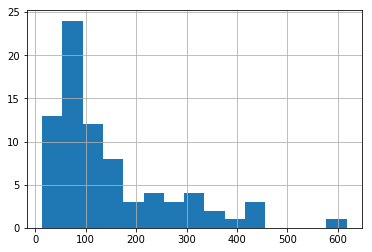

In [37]:
students_not_count_series.sort_values(ascending=False).hist(bins=15)

In [38]:
students_not_count_series.quantile([.1,.25, .5, .75, .9])

0.10     38.00
0.25     62.50
0.50    104.00
0.75    197.25
0.90    321.10
dtype: float64

Como da pra ver a distância é bem grande entre o 1ª quartil (.25) e o menores 10% assim como a distância é ainda mais grotesca com entre o 3ª quartil e o top 10%, quase o dobro de notificações recebidas.

## distribuição por nível de pendência
Os níveis de pendência variam entre 4 valores, sendo que o valor 1 e 2 representam o mesmo dado,
1. O valor 1 e 2 representam tarefas que ainda estão no prazo
2. O valor 3 representa tarefas que estão atrasadas
3. O valor 4 representa tarefas que não podem mais ser completadas/perdidas

In [39]:
notifications_with_user_grades_df.loc[notifications_with_user_grades_df["user"] == 14, ["v1", "v2"]].head(1)

,v1,v2
532,6.5,10.0


In [40]:
count_notification_level_by_user = notifications_with_user_grades_df.groupby(["user", "level"]).size()

In [41]:
count_notification_level_by_user.reset_index().pivot(index="user", columns="level", values=0).head(5)

level,1,2,3,4
user,,,,
11,71.0,NaN,179.0,95.0
12,45.0,NaN,2.0,NaN
13,58.0,NaN,39.0,43.0
14,23.0,NaN,7.0,43.0
15,64.0,NaN,76.0,43.0


# Indexando as notificações por tempo, análise temporal

In [42]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [43]:
notifications_with_user_grades_df.index = notifications_with_user_grades_df["creation_date"]

In [44]:
notifications_with_user_grades_df.index

DatetimeIndex(['2018-11-05', '2018-11-06', '2018-11-06', '2018-11-06',
               '2018-11-07', '2018-11-07', '2018-11-08', '2018-11-08',
               '2018-11-08', '2018-11-09',
               ...
               '2019-01-04', '2019-01-13', '2019-01-14', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22'],
              dtype='datetime64[ns]', name='creation_date', length=11404, freq=None)

In [45]:
notifications_with_user_grades_df.resample('M').agg({"v1": "mean", "v2": "mean"})

,v1,v2
creation_date,,
2018-11-30,4.025120,4.690423
2018-12-31,3.089561,3.603879
2019-01-31,4.214038,4.814518


Dado muito bom: a média de notificações visualizadas e quantidade de notificações visualizadas por semana de cada usuário

In [46]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date viewed     
                       mean  sum
0   11    2018-11-11    0.0  0.0
1   11    2018-11-18    0.0  0.0

In [47]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="M")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date    viewed     
                          mean  sum
0   11    2018-11-30  0.058824  9.0
1   11    2018-12-31  0.073770  9.0

# Associar recurso à pendência

In [48]:
pendencies_df.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model', 'pk'],
      dtype='object')

In [49]:
resources_flatten_df.columns

Index(['_my_subclass', 'all_students', 'brief_description', 'create_date',
       'groups', 'last_update', 'name', 'order', 'show_window', 'slug',
       'students', 'tags', 'topic', 'visible', 'model', 'pk'],
      dtype='object')

In [50]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [51]:
pendencies_with_resources = pd.merge(pendencies_df, resources_flatten_df, left_on=["resource"], right_on=["pk"])

In [52]:
pendencies_with_resources.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model_x', 'pk_x', '_my_subclass', 'all_students', 'brief_description',
       'create_date', 'groups', 'last_update', 'name', 'order', 'show_window',
       'slug', 'students', 'tags', 'topic', 'visible', 'model_y', 'pk_y'],
      dtype='object')

In [53]:
notications_with_resources_pendencies = pd.merge(notifications_with_user_grades_df, pendencies_with_resources, left_on=["task"], right_on=["pk_x"])

In [54]:
notications_with_resources_pendencies.shape

(11404, 36)

In [55]:
notications_with_resources_pendencies.dtypes

creation_date        datetime64[ns]
level                      category
meta                         object
task                         object
user                          int64
viewed                         bool
fields_x                     object
model                        object
pk                           object
id_estudante                  int64
v1                          float64
v2                          float64
action                     category
begin_date           datetime64[ns]
end_date             datetime64[ns]
limit_date           datetime64[ns]
resource                     object
fields_y                     object
model_x                      object
pk_x                         object
_my_subclass                 object
all_students                   bool
brief_description            object
create_date                  object
groups                       object
last_update                  object
name                         object
order                       

# Influência da notificação na V1

Para isto, só vou coletar notificações com pendências onde a data limite foi antes da data da v1

In [56]:
v1_notifications = notications_with_resources_pendencies[notications_with_resources_pendencies["end_date"] <= date_v1]\
.drop(columns=["v2"])
v1_notifications.index = v1_notifications["creation_date"]

In [57]:
v1_notifications.shape

(8408, 35)

Segundo a informação abaixo, pelo menos 75% possuem no mínimo 30 notificaçoes de pendências, e 50% possuem 71 notificações de pendências ou mais

In [58]:
v1_notifications.groupby("user").size().quantile([.1,.25, .5, .75, .9])

0.10     18.00
0.25     30.25
0.50     71.00
0.75    139.25
0.90    266.60
dtype: float64

In [59]:
v1_notifications.groupby(["user", pd.Grouper(freq="M")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date    viewed     
                          mean  sum
0   11    2018-11-30  0.058824  9.0
1   11    2018-12-31  0.076923  9.0

In [60]:
test_df = v1_notifications.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(10)

In [61]:
v1_notifications_viewed_date = v1_notifications.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index()

In [62]:
viewed_df = v1_notifications_viewed_date[["user", "creation_date"]]
viewed_df["mean"] = v1_notifications_viewed_date["viewed"]["mean"]
viewed_df["count"] = v1_notifications_viewed_date["viewed"]["sum"]

/home/bormann/anaconda3/envs/amadeus-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
def set_weeks_apart(df, date, date_column, week_diff_column):
    """
        Create a new column week_diff_column that contains the amount of weeks between the dates on the date_column
        of a given df to a related date
    """
    return df[date_column].apply(lambda dt: (dt - date).days//7)

In [64]:
set_weeks_apart(viewed_df, date_v1, "creation_date", "test")

0     -5
1     -4
2     -3
3     -2
4     -1
5      0
6      1
7      3
8      4
9      5
10     6
11    -5
12    -4
13    -3
14    -2
15    -5
16    -4
17    -3
18    -2
19    -1
20     0
21     1
22     3
23     4
24     5
25     6
26    -5
27    -4
28    -3
29    -2
      ..
549   -5
550   -4
551   -3
552   -2
553   -1
554    0
555    1
556    3
557    4
558    5
559    6
560   -5
561   -4
562   -3
563   -2
564   -1
565    0
566    1
567    3
568    4
569    5
570    6
571   -5
572   -4
573   -5
574   -4
575   -3
576   -2
577   -5
578   -4
Name: creation_date, Length: 579, dtype: int64

In [65]:
viewed_df.head(10)

,user,creation_date,mean,count
,,,,
0,11,2018-11-11,0.000000,0.0
1,11,2018-11-18,0.000000,0.0
2,11,2018-11-25,0.147541,9.0
3,11,2018-12-02,0.000000,0.0
4,11,2018-12-09,0.157895,9.0
5,11,2018-12-16,0.000000,0.0
6,11,2018-12-23,0.000000,0.0
7,11,2019-01-06,0.000000,0.0
8,11,2019-01-13,0.000000,0.0


In [66]:
v1_notifications_viewed_date[["user", "viewed"]]["viewed", "mean"]

0      0.000000
1      0.000000
2      0.147541
3      0.000000
4      0.157895
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.625000
12     0.714286
13     0.142857
14     0.200000
15     0.444444
16     0.562500
17     0.083333
18     0.545455
19     0.142857
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.500000
26     0.333333
27     0.666667
28     0.600000
29     0.142857
         ...   
549    0.000000
550    0.000000
551    0.230769
552    0.000000
553    0.000000
554    0.000000
555    0.000000
556    0.000000
557    0.000000
558    0.000000
559    0.000000
560    0.285714
561    0.666667
562    0.571429
563    0.285714
564    0.428571
565    0.000000
566    1.000000
567    0.000000
568    0.000000
569    0.428571
570    0.000000
571    0.100000
572    0.625000
573    0.357143
574    0.687500
575    0.043478
576    0.266667
577    0.875000
578    0.333333
Name: (viewed, mean), Le

In [67]:
v1_notifications_viewed_date.columns

MultiIndex(levels=[['viewed', 'creation_date', 'user'], ['mean', 'sum', '']],
           codes=[[2, 1, 0, 0], [2, 2, 0, 1]])

In [68]:
v1_notifications_viewed_date.columns.get_level_values(1)

Index(['', '', 'mean', 'sum'], dtype='object')

In [69]:
v1_notifications["name"].value_counts()

Definição de metas da 1ª Etapa    1624
Aula 09 (Resumo)                   901
Aula 07 (Resumo)                   756
Aula 08 (Resumo)                   655
Simulado 02                        612
Aula 03                            594
Aula 06                            591
Aula 02                            577
Aula 05 (Resumo)                   517
Aula 04 (Resumo)                   493
Aula 01                            443
Simulado 01                        350
Avaliação Diagnóstica              295
Name: name, dtype: int64

In [70]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & v1_notifications["viewed"]].shape

(877, 35)

In [71]:
v1_notifications[v1_notifications["name"].str.contains("Simulado")].shape

(962, 35)

In [72]:
v1_notifications["level"].value_counts()

3    4183
1    2472
4    1747
2       6
Name: level, dtype: int64

In [97]:
v1_notifications["simulado_delayed"] = v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 3)
v1_notifications["simulado_incompleted"] = v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 4)
v1_notifications["notes_delayed"] = v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 3)

In [ ]:
v1_notifications.groupby("user")

In [73]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 3)].shape

(63, 35)

In [74]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 4)].shape

(328, 35)

In [75]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 1)].shape

(568, 35)

In [76]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 3)].shape

(3964, 35)

In [96]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 1)].shape

(1560, 37)